## NREL

### Automated

In [1]:
import gc
import tempfile
import time
from concurrent.futures import ThreadPoolExecutor
from functools import partial
from pathlib import Path

import boto3
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from botocore import UNSIGNED
from botocore.client import Config
from ladybug.epw import EPW
from lightning.pytorch import Trainer
from ml.predict import predict_ubem
from ml.surrogate import Surrogate
from tqdm.notebook import tqdm
from weather.weather import extract

folder = Path("D:/DATA/resstock")
# folder = Path("c:/users/szvsw/downloads")
lookup_path = folder / "spatial_tract_lookup_table.csv"


surrogate_cache = {}
parquet_cache = {}
preds_cache = {}


# TODO: solar position computation; isolate and extract in climate
def calculate_dew_point(T, RH):
    # Constants for the Magnus-Tetens formula
    a = 17.62
    b = 243.12

    # Saturation vapor pressure (es)
    es = 6.112 * np.exp((a * T) / (b + T))

    # Actual vapor pressure (e)
    e = (RH / 100.0) * es

    # Dew point temperature (Td)
    Td = (b * np.log(e / 6.112)) / (a - np.log(e / 6.112))

    return Td


def download_and_open_epw_csv(
    s3_client, bucket: str, local_output_path: Path, key: str
):
    output_path = local_output_path / Path(key).name
    s3_client.download_file(
        Bucket=bucket,
        Key=key,
        Filename=output_path.as_posix(),
    )
    return pd.read_csv(output_path)


channel_map = {
    "dry_bulb_temperature": "Dry Bulb Temperature [°C]",
    "dew_point_temperature": lambda data: calculate_dew_point(
        data["Dry Bulb Temperature [°C]"], data["Relative Humidity [%]"]
    ),
    "relative_humidity": "Relative Humidity [%]",
    "wind_direction": "Wind Direction [Deg]",
    "wind_speed": "Wind Speed [m/s]",
    "direct_normal_radiation": "Direct Normal Radiation [W/m2]",
    "diffuse_horizontal_radiation": "Diffuse Horizontal Radiation [W/m2]",
    "solar_azimuth": None,
    "solar_elevation": None,
    "latitude": None,
    "longitude": None,
}


light_cols = [
    # "out.electricity.lighting_exterior.energy_consumption",
    # "out.electricity.lighting_garage.energy_consumption",
    "out.electricity.lighting_interior.energy_consumption",
    "out.natural_gas.lighting.energy_consumption",
]
elec_cols = [
    # "out.electricity.ceiling_fan.energy_consumption",
    "out.electricity.clothes_dryer.energy_consumption",
    "out.electricity.clothes_washer.energy_consumption",
    # "out.electricity.cooling_fans_pumps.energy_consumption",
    # "out.electricity.cooling.energy_consumption",
    "out.electricity.dishwasher.energy_consumption",
    "out.electricity.freezer.energy_consumption",
    # "out.electricity.heating_fans_pumps.energy_consumption",
    # "out.electricity.heating_hp_bkup.energy_consumption",
    # "out.electricity.heating.energy_consumption",
    # "out.electricity.hot_tub_heater.energy_consumption",
    # "out.electricity.hot_tub_pump.energy_consumption",
    # "out.electricity.hot_water.energy_consumption",
    # "out.electricity.lighting_exterior.energy_consumption",
    # "out.electricity.lighting_garage.energy_consumption",
    # "out.electricity.lighting_interior.energy_consumption",
    # "out.electricity.mech_vent.energy_consumption",
    "out.electricity.plug_loads.energy_consumption",
    # "out.electricity.pool_heater.energy_consumption",
    # "out.electricity.pool_pump.energy_consumption",
    # "out.electricity.pv.energy_consumption",
    "out.electricity.range_oven.energy_consumption",
    "out.electricity.refrigerator.energy_consumption",
    # "out.electricity.well_pump.energy_consumption",
    # "out.electricity.net.energy_consumption",
    # "out.electricity.total.energy_consumption",
]
res_thermal_output_cols = [
    "out.load.heating.energy_delivered.kbtu",
    "out.load.cooling.energy_delivered.kbtu",
]


def download_and_open_parquet(
    key: str,
    s3_client,
    bucket: str,
):
    with tempfile.TemporaryDirectory() as tmpdir:
        if key in parquet_cache:
            return parquet_cache[key]
        output_path = Path(tmpdir) / Path(key).name
        s3_client.download_file(
            Bucket=bucket,
            Key=key,
            Filename=output_path.as_posix(),
        )
        df_out = pd.read_parquet(output_path)
        df_out.set_index("timestamp", append=True, inplace=True)
        df_out = df_out[light_cols + elec_cols + res_thermal_output_cols]
        assert df_out.index.names == ["bldg_id", "timestamp"]
        assert df_out.index.get_level_values("bldg_id").nunique() == 1
        df_out.reset_index("bldg_id", drop=True, inplace=True)
        df_out.index = df_out.index - pd.Timedelta("15min")
        df_out = df_out.resample("1H").sum()
        # parquet_cache[key] = df_out
        return df_out


names = [
    "map_of_pumas_in_census_region_3_south.geojson",
    "map_of_pumas_in_census_region_1_northeast.geojson",
    "map_of_pumas_in_census_region_2_midwest.geojson",
    "map_of_pumas_in_census_region_4_west.geojson",
]
gdfs = []
for name in names:
    gdf = gpd.read_file(folder / name)
    gdfs.append(gdf)
gdf = pd.concat(gdfs)

Couldn't import dot_parser, loading of dot files will not be possible.


Load ResStock Features

In [2]:
# version = "v1"
version = "Infil"
resstock_path = folder / f"resstock_GA_VT_{version}.h5"

rs_df = pd.read_hdf(resstock_path, key="features")
rs_df.set_index(["building_id", "county"], inplace=True)
rs_df.drop_duplicates(inplace=True)

tract_df = pd.read_csv(lookup_path).set_index(
    "nhgis_county_gisjoin"
)  # nhgis_county_gisjoin
county_list = rs_df.index.get_level_values("county").unique().to_list()
counties_by_cz = {
    cz: rs_df[rs_df.climate_zone == cz]
    .index.get_level_values("county")
    .unique()
    .tolist()
    for cz in rs_df.climate_zone.unique()
}
czs = sorted(list(counties_by_cz.keys()))
run_counties = []
print(f"{len(county_list)} counties in resstock data, {len(rs_df)} buildings")


173 counties in resstock data, 18472 buildings


In [3]:
run_counties = []
counted_counties = (
    rs_df.set_index("climate_zone", append=True)
    .groupby(["climate_zone", "county"])
    .count()[["area"]]
    .rename(columns={"area": "count"})
)
counted_counties = (
    counted_counties.reset_index(["climate_zone"])
    .sort_values(["climate_zone", "count"], ascending=False)
    .reset_index()
    .set_index("climate_zone")
)
for cz in czs:
    counties_in_cz = counted_counties.loc[cz]
    run_counties.extend(counties_in_cz.iloc[:3]["county"].values.tolist())


In [4]:
# Override counties for testing
run_counties = ["G5000070", "G1300450"]  # VT and GA
# Override version
# version = "Infil_summer"


  0%|          | 0/2 [00:00<?, ?it/s]


 -------------------- G5000070 --------------------
Loading surrogate model from cache...
Surrogate model loaded.
Loading Data For County
GISMATCH                                                   5000100
GEOID                                                      5000100
STATEFIP                                                        50
State                                                      Vermont
PUMA                                                         00100
Name             Northwest Vermont--Chittenden, Franklin & Gran...
state_abbr                                                      VT
division_name                                          New England
region_name                                              Northeast
puma_tsv                                                 VT, 00100
geometry         MULTIPOLYGON (((-72.9521670005276 44.161271000...
Name: G50000100, dtype: object
done loading data for county: found 279 buildings
Preparing EPD/LPD features...
Done preparin

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\zoelh\AppData\Local\anaconda3\envs\ml-for-bem\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Done preparing weather
Clearing prediction cache.
Predicting UBEM...
Built dataset
Built dataloader
Predicting DataLoader 0: 100%|██████████| 34/34 [00:01<00:00, 17.38it/s]
Predicted!
setting index
Beginning evaluation...
Done evaluating.


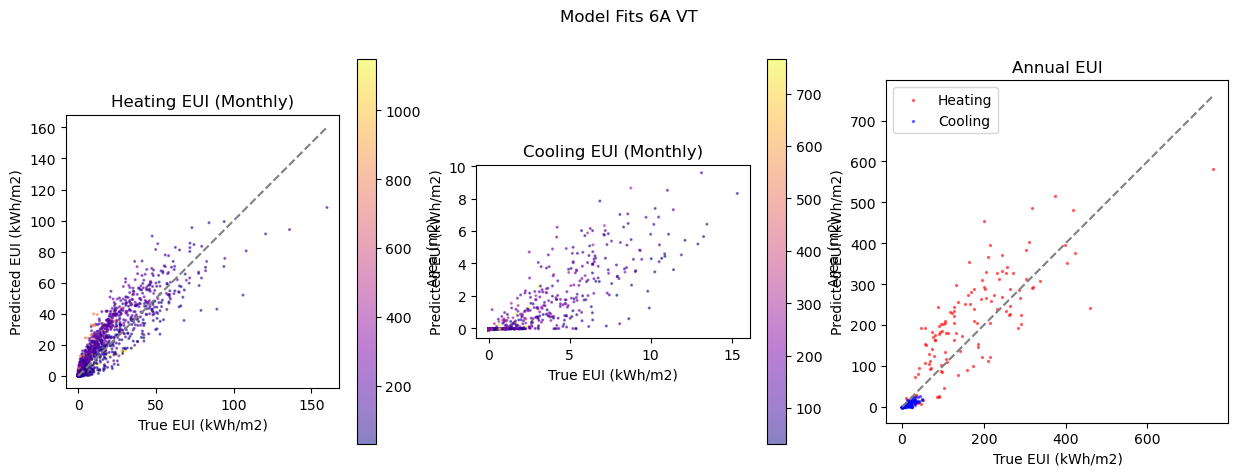

annual urban euis
               True        Pred
Name                           
Cooling    9.678683    4.047308
Heating  145.163578  198.250457
building errors
        Annual             Monthly           
        CVRMSE  NMBE  RMSE  CVRMSE  NMBE RMSE
Name                                         
Cooling   88.2 -58.4  10.8   112.9 -58.4  1.8
Heating   53.0  23.2  82.3    69.2  23.2  9.0

 -------------------- G1300450 --------------------
Loading surrogate model from cache...
Surrogate model loaded.
Loading Data For County
GISMATCH                                                   1302300
GEOID                                                      1302300
STATEFIP                                                        13
State                                                      Georgia
PUMA                                                         02300
Name             Three Rivers Regional Commission (Northwest)--...
state_abbr                                                      GA


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\zoelh\AppData\Local\anaconda3\envs\ml-for-bem\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Done preparing weather
Clearing prediction cache.
Predicting UBEM...
Built dataset
Built dataloader
Predicting DataLoader 0: 100%|██████████| 24/24 [00:01<00:00, 16.54it/s]
Predicted!
setting index
Beginning evaluation...
Done evaluating.


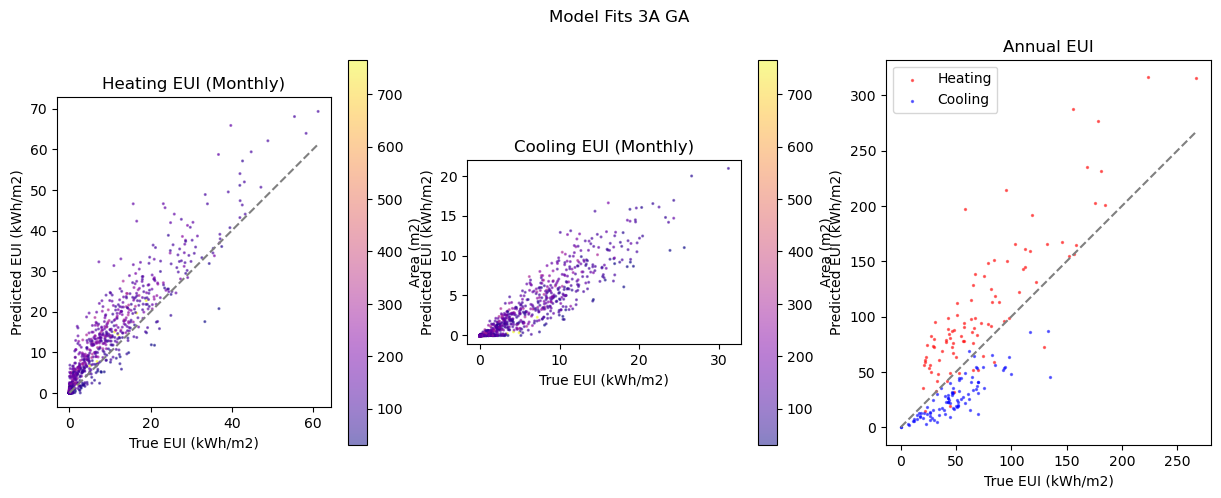

annual urban euis
              True        Pred
Name                          
Cooling  42.520347   24.659228
Heating  71.378817  107.546797
building errors
        Annual             Monthly           
        CVRMSE  NMBE  RMSE  CVRMSE  NMBE RMSE
Name                                         
Cooling   52.8 -43.2  25.6    71.3 -43.2  2.9
Heating   59.3  42.8  45.2    81.3  42.8  5.2


In [19]:
max_buildings = 1000  # set to None to run all in county
use_pred_caching = False
apply_cops = True
nrel_bucket = "oedi-data-lake"
# county_resource_dir = Path("c:/users/szvsw/downloads/county_resources")
county_resource_dir = Path("D:/DATA/resstock/county_resources")
dummy_epw_path = "data/epws/CAN_PQ_Montreal.Intl.AP.716270_CWEC.epw"
# dummy_epw_path = county_resource_dir / "G0500070_base_epw.epw"
res_schedule_path = Path("data/res_schedule.npy")
county_id = "G0500070"
# model config
registry = "ml-for-building-energy-modeling/model-registry"
model = "Global UBEM Shoebox Surrogate with Combined TS Embedder"
tag = "v3"
resource = "model.ckpt"

error_dfs = []
preds_dfs = []
ubem_dfs = []
for county_id in tqdm(run_counties):
    gc.collect()
    print("\n", "-" * 20, county_id, "-" * 20)
    # county_id = county_list[0]
    # county_id = counties_by_cz["6A"][0]

    surr_cache_key = f"{registry}/{model}/{tag}/{resource}"
    if surr_cache_key in surrogate_cache:
        print("Loading surrogate model from cache...")
        surrogate, trainer = surrogate_cache[surr_cache_key]
    else:
        print("Loading surrogate model from registry...")
        surrogate = Surrogate.load_from_registry(registry, model, tag, resource)
        surrogate.model.eval()
        torch.set_float32_matmul_precision("medium")
        trainer = Trainer(
            accelerator="auto",
            devices="auto",
            strategy="auto",
            enable_progress_bar=True,
        )
        surrogate_cache[surr_cache_key] = (surrogate, trainer)
    print("Surrogate model loaded.")

    print("Loading Data For County")
    county_data = tract_df[
        ["nhgis_puma_gisjoin", "weather_file_2018", "weather_file_TMY3"]
    ].loc[county_id]
    # assert county_data.nhgis_puma_gisjoin.nunique() < 5
    if isinstance(county_data.nhgis_puma_gisjoin, pd.Series):
        if county_data.nhgis_puma_gisjoin.nunique() > 5:
            print(
                f"County {county_id} has {county_data.nhgis_puma_gisjoin.nunique()} PUMAs; lat/lon may be off"
            )
        puma_join = county_data.nhgis_puma_gisjoin.values[0]
    else:
        puma_join = county_data.nhgis_puma_gisjoin

    row = gdf.set_index("GISJOIN").loc[puma_join]
    lon, lat = row.geometry.centroid.x, row.geometry.centroid.y
    print(row)
    county_features = rs_df.xs(county_id, level="county")
    print(f"done loading data for county: found {len(county_features)} buildings")

    occ_sched = np.load(res_schedule_path)[-1]
    s3_nrel = boto3.client("s3", config=Config(signature_version=UNSIGNED))
    county_resource_dir.mkdir(exist_ok=True, parents=True)
    if max_buildings is None:
        features = county_features.copy(deep=True)
    else:
        max_buildings_ = min(max_buildings, len(county_features))
        features = county_features.iloc[:max_buildings_]
    features = features.reset_index()
    # features = features[features.floors == 4]
    assert "building_id" in features.columns

    """
    ####################
    PULL BUILDING DATA
    ####################
    """
    results_files = features.results
    assert results_files.nunique() == len(features)

    with tempfile.TemporaryDirectory() as tempdir:
        cache_key = hash(f"{features.to_json()}")
        if cache_key in parquet_cache:
            df_out = parquet_cache[cache_key]
        else:
            dl_parquet = partial(
                download_and_open_parquet,
                s3_client=s3_nrel,
                bucket=nrel_bucket,
            )
            print(f"Attempting to pull {len(results_files)} parquet files...")
            with ThreadPoolExecutor(max_workers=14) as executor:
                df_out = pd.concat(
                    list(
                        tqdm(
                            executor.map(dl_parquet, results_files),
                            total=len(results_files),
                        )
                    ),
                    keys=features.building_id,
                )
            parquet_cache[cache_key] = df_out
            print(
                f"Succesfully pulled {df_out.index.get_level_values('building_id').nunique()} parquet files."
            )

    """
    ####################
    EPD/LPD HANDLING
    ####################
    """
    print("Preparing EPD/LPD features...")
    elec_kWh = df_out[elec_cols].sum(axis=1).unstack(level="building_id")
    lighting_kWh = df_out[light_cols].sum(axis=1).unstack(level="building_id")
    footprint_area = features.area.values
    n_floors = features.floors.values
    area = footprint_area  # * n_floors
    elec_W = elec_kWh * 1000
    lighting_W = lighting_kWh * 1000
    peak_elec = elec_W.max()
    peak_lighting = lighting_W.max()
    peak_elec = peak_elec.replace(0, 1)  # prevent divide by zero errors
    peak_lighting = peak_lighting.replace(0, 1)
    elec_W = elec_W.T
    lighting_W = lighting_W.T
    epd = peak_elec / area
    lpd = peak_lighting / area
    elec_frac = elec_W / peak_elec.values.reshape(-1, 1)
    lighting_frac = lighting_W / peak_lighting.values.reshape(-1, 1)
    del elec_kWh, lighting_kWh, elec_W, lighting_W
    gc.collect()
    if len(elec_frac) == 0:
        continue
    schedules = np.stack(
        [
            elec_frac.values,
            lighting_frac.values,
            occ_sched.reshape(1, 8760).repeat(len(features), axis=0),
        ],
        axis=1,
    )
    # matches the schedule stacking, each a unique schedule
    features["template_idx"] = range(len(features))
    assert (features.building_id == epd.index).all()
    assert (features.building_id == lpd.index).all()

    print("Done preparing EPD/LPD features.")

    """
    ####################
    FEATURE SETTING
    ####################
    """
    print("Preparing shoebox features...")
    for i in range(12):
        features[f"shading_{i}"] = 0

    # Set shading to right and left (45 deg.) to ShadHeight
    try:
        for i in [0, 1, 2, 8, 10, 11]:
            features[f"shading_{i}"] = features["ShadHeight"]
    except:
        pass

    features["EquipmentPowerDensity"] = epd.values
    features["LightingPowerDensity"] = lpd.values
    features["LightingPowerDensity"] = lpd.values
    features["RecoverySettings"] = 0
    # features["SlabRValue"] = 0.35
    # features["RoofRValue"] = features["RoofRValue"] / 2
    # features["FacadeRValue"] = features["FacadeRValue"] / 2
    # features["perim_depth"] = 3
    # features["core_depth"] = 7
    # features["ground_2_footprint"] = 1.0
    # features["roof_2_footprint"] = 1.0
    # features["RoofRValue"] = features["RoofRValue"] / 3

    # setpoint handling
    setpoints = features[["HeatingSetpoint", "CoolingSetpoint"]].values
    new_sp = np.ones_like(setpoints) * setpoints
    sp_crossover_violation = setpoints[:, 0] > setpoints[:, 1]
    new_sp[sp_crossover_violation, 0] = setpoints[sp_crossover_violation, 1] - 0.01
    assert (new_sp[:, 0] <= new_sp[:, 1]).all()
    # features["HeatingSetpoint"] = new_sp[:, 0]
    # features["CoolingSetpoint"] = new_sp[:, 1]
    print(f"{sp_crossover_violation.sum()} setpoints are crossed over.")
    hsp_conf = surrogate.space_config["HeatingSetpoint"]
    csp_conf = surrogate.space_config["CoolingSetpoint"]
    hsp_oob = (features["HeatingSetpoint"] > hsp_conf["max"]) | (
        features["HeatingSetpoint"] < hsp_conf["min"]
    )
    csp_oob = (features["CoolingSetpoint"] > csp_conf["max"]) | (
        features["CoolingSetpoint"] < csp_conf["min"]
    )
    sp_oob = hsp_oob | csp_oob
    print(
        f"{sp_oob.sum()} setpoints are out of bounds (heating: {hsp_oob.sum()}, cooling:{csp_oob.sum()})."
    )
    sp_error_mask = sp_crossover_violation | sp_oob
    print(f"{sp_error_mask.sum()} buildings have setpoint errors.")
    features = features[~sp_error_mask]
    df_out = df_out[
        df_out.index.get_level_values("building_id").isin(features.building_id)
    ]

    print(f"{len(features)} buildings remain after setpoint errors.")

    #################### Infiltration Handling
    # original_infil_min = features.Infiltration.min()
    # original_infil_max = features.Infiltration.max()
    # infil_range = original_infil_max - original_infil_min
    # infil_range = np.where(np.abs(infil_range - 0) > 1e-6, infil_range, 1)
    # original_infil_scalar = (
    #     features.Infiltration.values.reshape(-1, 1) - original_infil_min
    # ) / (infil_range.reshape(-1, 1)) * 2 - 1
    # winter_infil = 0.000075
    # summer_infil = 0.001
    # winter_infil_var_percent = 0.5
    # summer_infil_var_percent = 0.2
    # # winter_infil = 0.0001
    # # summer_infil = 0.001
    # # winter_infil_var_percent = 0.0
    # # summer_infil_var_percent = 0.0
    # features["WinterInfiltration"] = (
    #     winter_infil + winter_infil * winter_infil_var_percent * original_infil_scalar
    # )
    # features["SummerInfiltration"] = (
    #     summer_infil + summer_infil * summer_infil_var_percent * original_infil_scalar
    # )

    # NEW INFILTRATION
    summer_infil = 0.0001
    summer_infil_var_percent = 0.2
    features["WinterInfiltration"] = features.Infiltration
    # features["SummerInfiltration"] = features.Infiltration
    features["SummerInfiltration"] = (
        summer_infil + summer_infil * summer_infil_var_percent * features.Infiltration
    )


    ##### Finalizing

    features["weight"] = 0.25
    features = features.set_index("building_id")
    bldg_ids = features.index.values

    ############## Shoebox Generation
    # 8 sb per building because 4 orientations and 2 seasons with different infiltration rates
    bldg_ids_for_sb = np.repeat(bldg_ids, 8)
    is_summer = np.tile(np.array([False, True]), len(bldg_ids)).repeat(4)
    sb_features = features.loc[bldg_ids_for_sb]
    sb_features["is_summer"] = is_summer
    sb_features["sb_orientation_ix"] = np.tile(np.tile(np.arange(4), len(bldg_ids)), 2)
    sb_features["orientation"] = (
        sb_features.sb_orientation_ix / 4 * 2 * np.pi + sb_features.orientation
    ) % (2 * np.pi)
    # sb_features.loc[~sb_features.is_summer, "Infiltration"] = winter_infil
    # sb_features.loc[sb_features.is_summer, "Infiltration"] = summer_infil
    sb_features.loc[~sb_features.is_summer, "Infiltration"] = sb_features.loc[
        ~sb_features.is_summer, "WinterInfiltration"
    ]
    sb_features.loc[sb_features.is_summer, "Infiltration"] = sb_features.loc[
        sb_features.is_summer, "SummerInfiltration"
    ]

    sb_features = sb_features.reset_index()
    sb_features.loc[sb_features.is_summer, "building_id"] = -sb_features.loc[
        sb_features.is_summer, "building_id"
    ]

    print("Done preparing shoebox features.")

    """
    ####################
    WEATHER
    ####################
    """
    print("Preparing weather...")
    if len(features) == 0:
        continue
    epw_files = features.epw.unique()
    assert len(epw_files) == 1
    epw_file = epw_files[0]
    print(
        f"Will process {len(features)}/{len(county_features)} buildings in {county_id} county."
    )
    # TODO: we can manually construct climate directly from climate_csv
    # if we can compute the lat/lon directly from the county code.
    #  once we have lat lon we can also compute solar positions identically to as in 'extract'
    # Instead, we have to open the original location based epw, and then overwrite with data from the downloaded csv
    epw = EPW(dummy_epw_path)
    epw.location.latitude = lat
    epw.location.longitude = lon
    climate = extract(epw, surrogate.weather_transform.channel_names)
    epw_csv_data = download_and_open_epw_csv(
        s3_client=s3_nrel,
        bucket=nrel_bucket,
        local_output_path=county_resource_dir,
        key=epw_file,
    )
    for key, val in channel_map.items():
        if val is None:
            continue
        if isinstance(val, str):
            climate[
                surrogate.weather_transform.channel_names.index(key)
            ] = epw_csv_data[val].values
        elif callable(val):
            climate[surrogate.weather_transform.channel_names.index(key)] = val(
                epw_csv_data
            )

    print("Done preparing weather")

    """
    ####################
    PREDICTIONS
    ####################
    """
    cache_key = hash(f"{(sb_features.to_json(), schedules, climate)}")
    if not use_pred_caching:
        print("Clearing prediction cache.")
        preds_cache = {}
    if cache_key in preds_cache and use_pred_caching:
        sb_preds, monthly_preds, annual_preds = preds_cache[cache_key]
    else:
        sb_preds, monthly_preds, annual_preds = predict_ubem(
            trainer=trainer,
            surrogate=surrogate,
            features=sb_features,
            schedules=schedules,
            climate=climate,
            apply_cops=apply_cops,
            batch_size=32,
        )
        del schedules
        gc.collect()
        monthly_preds["Cooling"] = monthly_preds.loc[
            -monthly_preds.index, "Cooling"
        ].values
        monthly_preds = monthly_preds.loc[monthly_preds.index > 0]
        annual_preds["Cooling"] = annual_preds.loc[
            -annual_preds.index, "Cooling"
        ].values
        annual_preds = annual_preds.loc[annual_preds.index > 0]
        no_thermal = df_out[res_thermal_output_cols].groupby("building_id").sum() < 0.1
        no_heating = no_thermal["out.load.heating.energy_delivered.kbtu"]
        no_cooling = no_thermal["out.load.cooling.energy_delivered.kbtu"]
        monthly_preds.loc[:, ("Heating", slice(None))] = monthly_preds.loc[
            :, ("Heating", slice(None))
        ] * (~no_heating).values.reshape(-1, 1)
        monthly_preds.loc[:, ("Cooling", slice(None))] = monthly_preds.loc[
            :, ("Cooling", slice(None))
        ] * (~no_cooling).values.reshape(-1, 1)
        annual_preds.loc[:, "Heating"] = annual_preds["Heating"] * (~no_heating)
        annual_preds.loc[:, "Cooling"] = annual_preds["Cooling"] * (~no_cooling)

        preds_cache[cache_key] = (
            sb_preds,
            monthly_preds,
            annual_preds,
        )

    """
    ####################
    EVALUATION
    ####################
    """
    print("Beginning evaluation...")
    area = features.area.values.reshape(-1, 1)
    kWh_per_kBtu = 1 / 3.412
    y_true = df_out[
        [
            "out.load.heating.energy_delivered.kbtu",
            "out.load.cooling.energy_delivered.kbtu",
        ]
    ]
    del df_out
    gc.collect()
    y_true.columns = ["Heating", "Cooling"]
    monthly_preds = monthly_preds[y_true.columns]

    y_true = y_true.unstack(level="building_id")
    y_true = y_true.resample("1M").sum()
    y_true = (
        y_true.stack(level="building_id").unstack(level="timestamp")
        * kWh_per_kBtu
        / area
    )
    y_true.columns = monthly_preds.columns
    if apply_cops:
        y_true["Cooling"] = y_true["Cooling"] / features.cop_cooling.values.reshape(
            -1, 1
        )
        y_true["Heating"] = y_true["Heating"] / features.cop_heating.values.reshape(
            -1, 1
        )

    annual_eui_true = y_true.T.groupby("Name").sum().T
    annual_gross_true = annual_eui_true * area
    annual_gross_preds = annual_preds * area
    annual_urban_gross_true = annual_gross_true.sum()
    annual_urban_gross_preds = annual_gross_preds.sum()
    annual_urban_eui_true = annual_urban_gross_true / area.sum()
    annual_urban_eui_preds = annual_urban_gross_preds / area.sum()
    annual_urban_eui = pd.concat(
        [annual_urban_eui_true, annual_urban_eui_preds], axis=1, keys=["True", "Pred"]
    )

    rmse_annual = (annual_eui_true - annual_preds).pow(2).mean().pow(0.5)
    cvrmse_annual = rmse_annual / annual_eui_true.mean()
    nmbe_annual = (annual_preds - annual_eui_true).mean() / annual_eui_true.mean()
    rmse_monthly = (
        (monthly_preds - y_true).pow(2).mean().groupby("Name").mean().pow(0.5)
    )
    cvrmse_monthly = rmse_monthly / y_true.mean().groupby("Name").mean()
    nmbe_monthly = (monthly_preds - y_true).mean().groupby(
        "Name"
    ).mean() / y_true.mean().groupby("Name").mean()
    rmse = pd.concat(
        [rmse_annual, rmse_monthly], axis=1, keys=["Annual", "Monthly"]
    ).round(1)
    cvrmse = (
        pd.concat([cvrmse_annual, cvrmse_monthly], axis=1, keys=["Annual", "Monthly"])
        * 100
    ).round(1)
    nmbe = (
        pd.concat([nmbe_annual, nmbe_monthly], axis=1, keys=["Annual", "Monthly"]) * 100
    ).round(1)
    errors = (
        pd.concat([rmse, cvrmse, nmbe], axis=1, keys=["RMSE", "CVRMSE", "NMBE"])
        .swaplevel(axis=1)
        .sort_index(axis=1)
    )
    errors
    print("Done evaluating.")
    """
    ####################
    PLOTTING
    ####################
    """
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    plt.suptitle(f"Model Fits {features.iloc[0].climate_zone} {features.iloc[0].state}")
    for i, target in enumerate(["Heating", "Cooling"]):
        y_true_col = y_true[target].values.flatten()
        y_pred_col = monthly_preds[target].values.flatten()
        sc = ax[i].scatter(
            y_true_col,
            y_pred_col,
            s=1.5,
            alpha=0.5,
            # color="blue" if target == "Cooling" else "red",
            c=county_features.loc[monthly_preds.index].area.values.repeat(12),
            cmap="plasma",
            label=target,
        )
        ax[i].plot(
            [0, y_true_col.max()],
            [0, y_true_col.max()],
            color="gray",
            linestyle="--",
        )
        fig.colorbar(sc, ax=ax[i], label="Area (m2)")
        ax[i].set_xlabel("True EUI (kWh/m2)")
        ax[i].set_ylabel("Predicted EUI (kWh/m2)")
        ax[i].set_title(f"{target} EUI (Monthly)")
        ax[i].set_aspect("equal", adjustable="box")

        ax[2].scatter(
            annual_eui_true[target],
            annual_preds[target],
            color="blue" if target == "Cooling" else "red",
            label=target,
            s=2,
            alpha=0.5,
        )
    ax[2].set_title("Annual EUI")
    ax[2].set_xlabel("True EUI (kWh/m2)")
    ax[2].set_ylabel("Predicted EUI (kWh/m2)")
    ax[2].plot(
        [0, annual_eui_true.max().max()],
        [0, annual_eui_true.max().max()],
        color="gray",
        linestyle="--",
    )
    ax[2].set_aspect("equal", adjustable="box")
    ax[2].legend()
    plt.show()

    fig.tight_layout()

    print("annual urban euis")
    print(annual_urban_eui)
    print("building errors")
    print(errors)

    """
    ####################
    SAVE RESULTS
    ####################
    """
    X = features.reset_index()
    df = pd.concat(
        [monthly_preds, y_true], axis=1, keys=["Predicted", "True"], names=["Segment"]
    )
    assert (df.index.values == X.building_id.values).all()
    df.index = pd.MultiIndex.from_frame(X)
    fp = f"resstock_validation_{county_id}_{version}.hdf"
    df.to_hdf(fp, mode="w", key="preds_and_true")
    errors.to_hdf(fp, mode="a", key="errors")
    annual_urban_eui.to_hdf(fp, mode="a", key="urban_eui")
    preds_dfs.append(df)
    error_dfs.append(errors)
    ubem_dfs.append(annual_urban_eui)

    gc.collect()


### Results

In [142]:
load_from_disk = False
matcher = "resstock_validation_*_worse_envelope.hdf"
if load_from_disk:
    preds_dfs = []
    ubem_dfs = []
    error_dfs = []
    for file in Path(".").glob(matcher):
        error_dfs.append(pd.read_hdf(file, key="errors"))
        ubem_dfs.append(pd.read_hdf(file, key="urban_eui"))
        preds_dfs.append(pd.read_hdf(file, key="preds_and_true"))

all_errors = pd.concat(error_dfs, axis=0, keys=run_counties, names=["county"])
all_urbans = pd.concat(ubem_dfs, axis=0, keys=run_counties, names=["county"])
all_preds = pd.concat(preds_dfs, axis=0, keys=run_counties, names=["county"])
all_preds.columns.names = ["segment", "end_use", "month"]
all_areas = all_preds.index.get_level_values("area")
total_monthly_energy = all_preds * all_areas.values.reshape(-1, 1)


In [143]:
len(all_areas)


230

In [144]:
# TODO: predict total energy usage for the counties by buildings; see how well we predict each county.
data = all_preds
# data = total_monthly_energy
res = (all_preds["Predicted"] - all_preds["True"]).T.groupby("end_use").sum().T
squared_error = res.pow(2)
mse_by_cz_and_end_use = squared_error.groupby("climate_zone").mean().sort_index()
true_mean_by_cz_and_end_use = (
    all_preds["True"]
    .T.groupby("end_use")
    .sum()
    .T.groupby("climate_zone")
    .mean()
    .sort_index()
)
cvrmse_by_cz_and_end_use = (
    mse_by_cz_and_end_use.pow(0.5) / true_mean_by_cz_and_end_use
).sort_index() * 100
cvrmse_by_cz_and_end_use
nmbe_by_end_cz_and_end_use = (
    res.groupby("climate_zone").mean().sort_index() / true_mean_by_cz_and_end_use * 100
)
(nmbe_by_end_cz_and_end_use).round(1)


end_use,Cooling,Heating
climate_zone,,
3A,-35.3,10.7
6A,-56.9,-6.1


In [36]:
national_energy_use = total_monthly_energy.sum().groupby(["segment", "end_use"]).sum()
national_energy_percent_error = (
    (national_energy_use["Predicted"] - national_energy_use["True"])
    / national_energy_use["True"]
).sort_index()
national_energy_percent_error * 100


end_use
Cooling    7.405242
Heating    6.831756
dtype: float64

C:\Users\zoelh\AppData\Local\Temp\ipykernel_61796\3072582434.py:2: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  annual = stacked[stacked.index.isin([county], level=0)].sum(axis=0, level=1)


Text(0, 0.5, 'Predicted EUI (kWh/m2)')

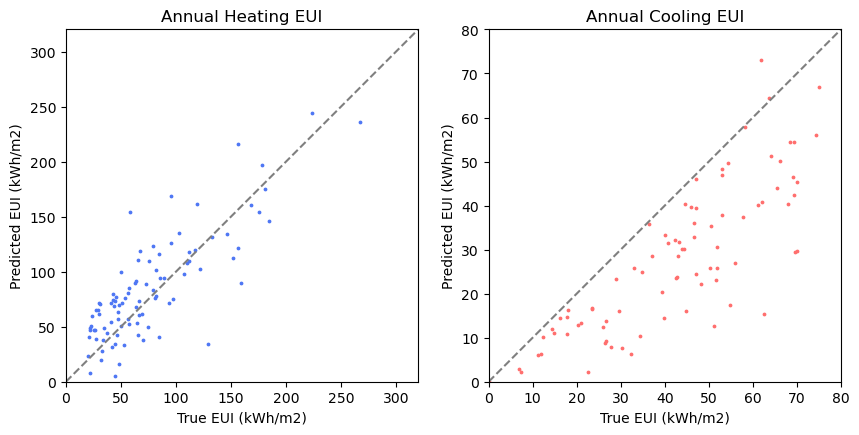

In [167]:
county = "G1300450"
annual = stacked[stacked.index.isin([county], level=0)].sum(axis=0, level=1)
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

scale_y = 2
psize = 3
a = 1

ax[0].scatter(
    annual["True"].Heating,
    annual["Predicted"].Heating,
    s=psize,
    alpha=a,
    color="#4f77f4",
)
ax[0].set_aspect("equal", adjustable="box")
max_y = max(stacked["True"].Heating.max() * scale_y, 80)
ax[0].plot(
    [0, max_y],
    [0, max_y],
    linestyle="--",
    color="gray",
)
ax[0].set_ylim(0, max_y)
ax[0].set_xlim(0, max_y)
ax[0].set_title("Annual Heating EUI")
ax[0].set_xlabel("True EUI (kWh/m2)")
ax[0].set_ylabel("Predicted EUI (kWh/m2)")

ax[1].scatter(
    annual["True"].Cooling,
    annual["Predicted"].Cooling,
    s=psize,
    alpha=a,
    color="#ff6f6e",
)
ax[1].set_aspect("equal", adjustable="box")
scale_y = 0.5
max_y = max(stacked["True"].Cooling.max() * scale_y, 80)
ax[1].plot(
    [0, max_y],
    [0, max_y],
    linestyle="--",
    color="gray",
)
ax[1].set_ylim(0, max_y)
ax[1].set_xlim(0, max_y)
ax[1].set_title("Annual Cooling EUI")
ax[1].set_xlabel("True EUI (kWh/m2)")
ax[1].set_ylabel("Predicted EUI (kWh/m2)")

Text(0, 0.5, 'Predicted EUI (kWh/m2)')

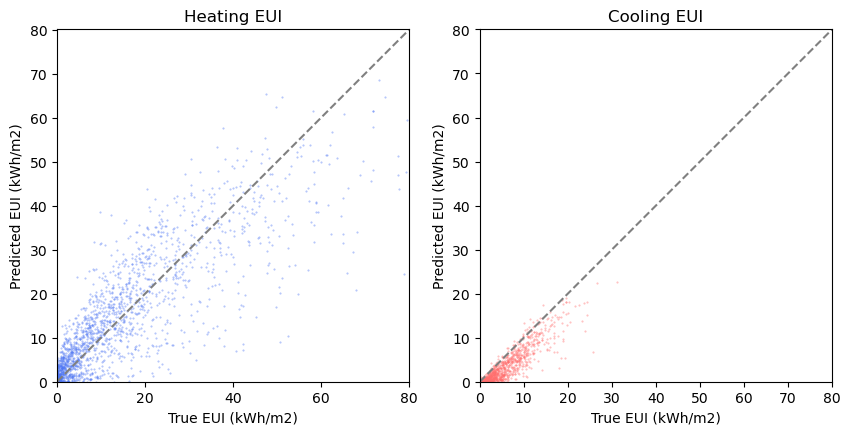

In [145]:
stacked = all_preds.stack(level=["month"])
c = pd.Series(stacked.index.get_level_values("climate_zone")).apply(
    lambda x: czs.index(x)
)
scale_y = 0.5
psize = 0.2
a = 0.5

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].scatter(
    stacked["True"].Heating,
    stacked["Predicted"].Heating,
    s=psize,
    alpha=a,
    color="#4f77f4",
)
ax[0].set_aspect("equal", adjustable="box")
max_y = max(stacked["True"].Heating.max() * scale_y, 80)
ax[0].plot(
    [0, max_y],
    [0, max_y],
    linestyle="--",
    color="gray",
)
ax[0].set_ylim(0, max_y)
ax[0].set_xlim(0, max_y)
ax[0].set_title("Heating EUI")
ax[0].set_xlabel("True EUI (kWh/m2)")
ax[0].set_ylabel("Predicted EUI (kWh/m2)")

ax[1].scatter(
    stacked["True"].Cooling,
    stacked["Predicted"].Cooling,
    s=psize,
    alpha=a,
    color="#ff6f6e",
)
ax[1].set_aspect("equal", adjustable="box")
scale_y = 0.5
max_y = max(stacked["True"].Cooling.max() * scale_y, 80)
ax[1].plot(
    [0, max_y],
    [0, max_y],
    linestyle="--",
    color="gray",
)
ax[1].set_ylim(0, max_y)
ax[1].set_xlim(0, max_y)
ax[1].set_title("Cooling EUI")
ax[1].set_xlabel("True EUI (kWh/m2)")
ax[1].set_ylabel("Predicted EUI (kWh/m2)")


In [58]:
rs_df.loc[
    rs_df.index.get_level_values("county").isin(
        all_preds.index.get_level_values("county")
    )
].index.get_level_values("county").value_counts().sort_index()
all_preds.index.get_level_values("county").value_counts().sort_index()


G0600010      39
G0600170      37
G0600250     120
G0600370      39
G0600590      42
G0600730      39
G0600750      41
G0600850      43
G0800310      47
G0800370      20
G0800410      43
G0800490      10
G0801070      15
G0801170      18
G1200110    1860
G1200860    2341
G1200870      96
G1200990     112
G1301210      38
G1700310      31
G2300030      19
G2500170      39
G2601630      29
G2700350      21
G2700530      40
G2701370      16
G3600470      33
G3600610      30
G3600810      37
G4800290     137
G4801130      37
G4802010     132
G4803750      34
G4803810      44
G4804390      39
G4804650      49
G4804790     154
G4900050      36
G4900350      43
G4900430      32
G5300330      45
G5300530      39
G5300610      51
G5500250      49
G5500790      40
Name: county, dtype: int64

In [53]:
total_monthly_res = total_monthly_energy["Predicted"] - total_monthly_energy["True"]
national_monthly_nmbe = (
    total_monthly_res.mean().groupby("end_use").mean()
    / total_monthly_energy["True"].mean().groupby("end_use").mean()
    * 100
)

total_county_area = all_preds.index.to_frame()[["area"]].groupby("county").sum()
total_county_energy = (
    total_monthly_energy.groupby("county").sum().T.groupby(["segment"]).sum().T
)
assert (total_county_energy.index == total_county_area.index).all()
total_county_eui = total_county_energy / total_county_area.values.reshape(-1, 1)
county_level_mape = (
    (total_county_energy["Predicted"] - total_county_energy["True"]).abs()
    / total_county_energy["True"]
).mean() * 100
county_level_eui_mape = (
    (total_county_eui["Predicted"] - total_county_eui["True"]).abs()
    / total_county_eui["True"]
).mean() * 100  # always identical to county_level_mape
total_county_energy_by_end_use = (
    total_monthly_energy.groupby("county")
    .sum()
    .T.groupby(["segment", "end_use"])
    .sum()
    .T
)
total_county_eui_by_end_use = (
    total_county_energy_by_end_use / total_county_area.values.reshape(-1, 1)
)
total_county_residual_by_end_use = (
    total_county_energy_by_end_use["Predicted"] - total_county_energy_by_end_use["True"]
)
total_county_eui_residual_by_end_use = (
    total_county_eui_by_end_use["Predicted"] - total_county_eui_by_end_use["True"]
)
total_county_rmse_by_end_use = total_county_residual_by_end_use.pow(2).mean().pow(0.5)
total_county_eui_rmse_by_end_use = (
    total_county_eui_residual_by_end_use.pow(2).mean().pow(0.5)
)
total_county_cvrmse_by_end_use = (
    total_county_rmse_by_end_use / total_county_energy_by_end_use["True"].mean() * 100
)
total_county_eui_cvrmse_by_end_use = (
    total_county_eui_rmse_by_end_use / total_county_eui_by_end_use["True"].mean() * 100
)
total_county_eui_cvrmse_by_end_use
county_level_mape, county_level_eui_mape


(18.757413607758508, 18.75741360775851)